# **Time-Series Model Task**
### Elsun Nabatov

### **Introduction**

In this task, I aim to harness historical login/logout data to predict future usage patterns within a university's computer network. Specifically, I will focus on forecasting the next 100 login/logout times, the subsequent 100 counts of students utilizing the computers, and the identification of the next 100 cluster names associated with these login/logout events, employing machine learning techniques to achieve precise predictions.

### **Data Loading and Preprocessing**

In this section of the report, I begin analysis by loading the data from UserLog.csv into a Pandas DataFrame, a versatile data structure that allows for easy data manipulation and analysis. 

#### Importing Libraries and Data

In [1]:
import pandas as pd
file_path = 'UserLog.csv'
column_names = ['Date and Time', 'Event Type', 'Cluster', 'Duration (ms)', 'Total Users Logged In']
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, header=None, names=column_names)

# Display the first few rows of the DataFrame to verify it's loaded correctly
print(df.head())

                  Date and Time Event Type Cluster  Duration (ms)  \
0  Fri Jan 01 00:00:00 GMT 2010      LOGIN    FELL        1261840   
1  Fri Jan 01 00:00:00 GMT 2010      LOGIN    LAKE       10058927   
2  Fri Jan 01 00:00:00 GMT 2010      LOGIN    SIDE        6868990   
3  Fri Jan 01 00:00:00 GMT 2010      LOGIN    LAKE        2997017   
4  Fri Jan 01 00:00:00 GMT 2010      LOGIN    LAKE        8919800   

   Total Users Logged In  
0                      1  
1                      2  
2                      3  
3                      4  
4                      5  


Checking missing values

In [2]:
# Check for missing values
print(df.isnull().sum())

Date and Time            0
Event Type               0
Cluster                  0
Duration (ms)            0
Total Users Logged In    0
dtype: int64


#### Convert "Date and Time" to Datetime Format and Handle Missing Values

Dataset contains timestamps that need to be correctly handled to reflect the local time in the UK. I create a timezone object for the UK and use Pandas' datetime functionalities to convert the 'Date and Time' column to the correct timezone. 

In [3]:
import pandas as pd
import pytz

# Create a timezone object for UK time
uk_timezone = pytz.timezone('Europe/London')

# Convert 'Date and Time' column to datetime, localize to UTC, and then convert to UK timezone
df['Date and Time'] = pd.to_datetime(df['Date and Time'], errors='coerce').dt.tz_localize('UTC').dt.tz_convert(uk_timezone)

# Optionally remove the timezone information after conversion
df['Date and Time'] = df['Date and Time'].dt.tz_localize(None)

# Proceed with setting 'Date and Time' as index and further preprocessing
df.set_index('Date and Time', inplace=True)

## **Exploratory Data Analysis**

#### Overall activity trend

There's a visible trend in the data, with fluctuations in the number of events across different times of the year. There are peaks and troughs in the data, which could represent special events (e.g., exams, holidays) affecting login/logout activities.

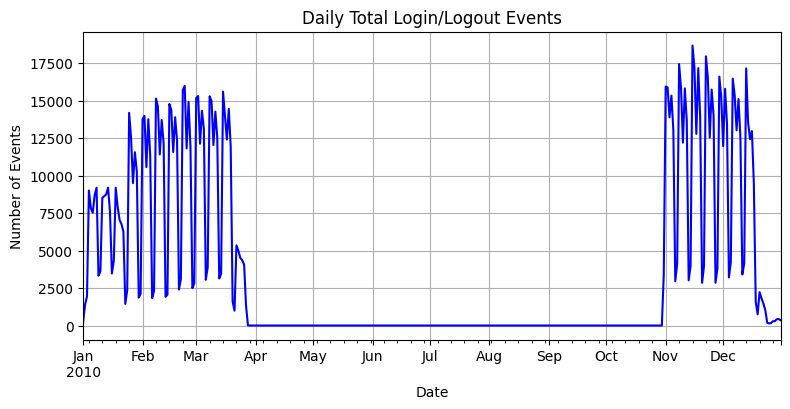

In [4]:
import matplotlib.pyplot as plt

# 'Date and Time' column is used as the index for easier plotting
df.set_index('Date and Time', inplace=True)

# Resample data to get daily counts of events for plotting
daily_events = df.resample('D').size()

# Plotting the overall activity trends over time
plt.figure(figsize=(9, 4))
daily_events.plot(title='Daily Total Login/Logout Events', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()

### **Daily Pattern**

There's a noticeable pattern where certain days of the week exhibit higher activity than others. This pattern could be influenced by the academic or operational schedule of the university, with weekdays generally showing higher activity compared to weekends. The decrease in activity during the weekends (Saturday and Sunday) is evident, which aligns with typical user behavior in educational or corporate environments.

For each day of the week, the number of login and logout events remains relatively consistent with each other, reinforcing the expectation that each login is paired with a corresponding logout, albeit with potential differences in session durations.

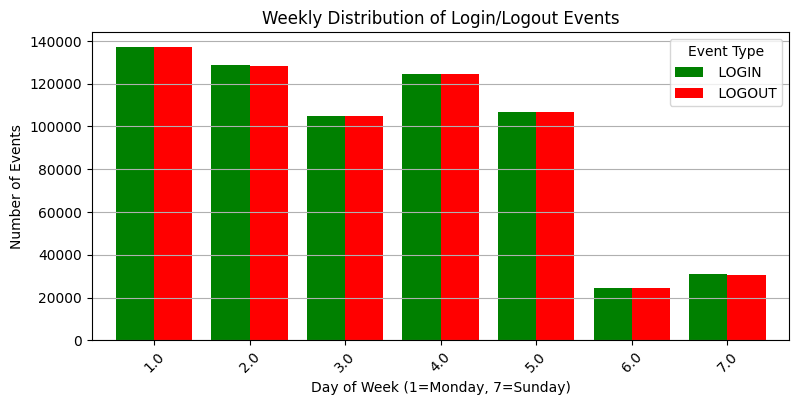

In [5]:
# Extracting day of the week for each event (Monday=1, Sunday=7)
df['Day of Week'] = df.index.dayofweek + 1

# Grouping by day of the week and event type to count occurrences
weekly_pattern = df.groupby(['Day of Week', 'Event Type']).size().unstack()

# Plotting weekly patterns
weekly_pattern.plot(kind='bar', figsize=(9, 4), width=0.8, color=['green', 'red'])
plt.title('Weekly Distribution of Login/Logout Events')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Event Type')
plt.show()


### **Cluster Activity**

There's a clear variation in the level of activity among different clusters, indicating that some clusters are utilized more heavily than others. This could reflect the physical location, available resources, or specific purposes associated with each cluster.

Across most clusters, the number of login events closely matches the number of logout events, as expected. However, the variation in total activity could indicate differing user preferences, capacities, or specializations of the clusters.

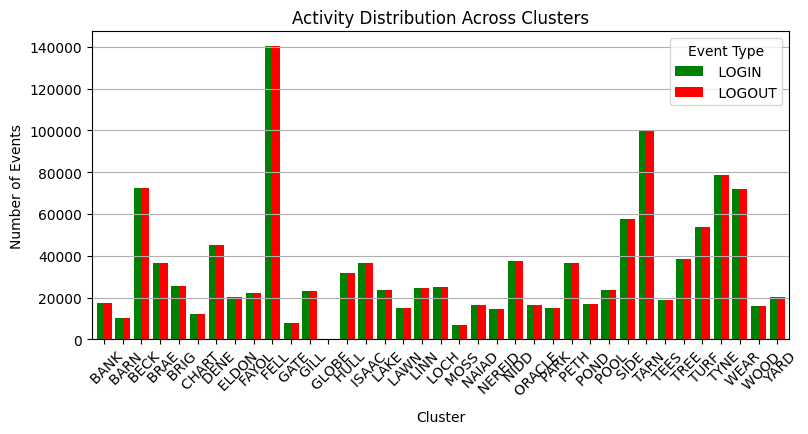

In [6]:
# Grouping by cluster to count occurrences of each event type
cluster_activity = df.groupby(['Cluster', 'Event Type']).size().unstack()

# Plotting the activity distribution across clusters
cluster_activity.plot(kind='bar', figsize=(9, 4), width=0.8, color=['green', 'red'])
plt.title('Activity Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Event Type')
plt.show()

## Part 1

This part presents the development and evaluation of a predictive model designed to forecast the next 100 login/logout events at a university using historical time-series data. Our approach utilizes machine learning techniques to discern patterns from past user activity and project future computer usage trends.

#### **Data Preprocessing and Feature Engineering for LSTM**

I preprocess the raw data to convert event timestamps to a consistent timezone, aggregate events to daily counts, and normalize these counts for predictive modeling. Aim is to forecast the next 100 login/logout events, leveraging Long Short-Term Memory (LSTM) networks for their ability to handle sequential data.

Load and Explore the Dataset

In [4]:
# Load the dataset
file_path = 'UserLog.csv'
column_names = ['Date and Time', 'Event Type', 'Cluster', 'Duration (ms)', 'Total Users Logged In']
df = pd.read_csv(file_path, header=None, names=column_names)

# Display the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

                  Date and Time Event Type Cluster  Duration (ms)  \
0  Fri Jan 01 00:00:00 GMT 2010      LOGIN    FELL        1261840   
1  Fri Jan 01 00:00:00 GMT 2010      LOGIN    LAKE       10058927   
2  Fri Jan 01 00:00:00 GMT 2010      LOGIN    SIDE        6868990   
3  Fri Jan 01 00:00:00 GMT 2010      LOGIN    LAKE        2997017   
4  Fri Jan 01 00:00:00 GMT 2010      LOGIN    LAKE        8919800   

   Total Users Logged In  
0                      1  
1                      2  
2                      3  
3                      4  
4                      5  
Date and Time            0
Event Type               0
Cluster                  0
Duration (ms)            0
Total Users Logged In    0
dtype: int64


Convert "Date and Time" to Datetime Format and Handle Missing Values

In [5]:
# Convert "Date and Time" to datetime format
df['Date and Time'] = pd.to_datetime(df['Date and Time'], errors='coerce')

# Drop rows with null "Date and Time"
df = df.dropna(subset=['Date and Time'])

# Check the first few rows to confirm changes
print(df.head())

  Date and Time Event Type Cluster  Duration (ms)  Total Users Logged In
0    2010-01-01      LOGIN    FELL        1261840                      1
1    2010-01-01      LOGIN    LAKE       10058927                      2
2    2010-01-01      LOGIN    SIDE        6868990                      3
3    2010-01-01      LOGIN    LAKE        2997017                      4
4    2010-01-01      LOGIN    LAKE        8919800                      5


### Feature Engineering

In this phase of analysis, I enriched dataset with time-related features to uncover insights into usage patterns. By extracting the hour of the day and the day of the week from each event, I aim to identify peak times and weekly trends, while the computation of time differences between events helps in understanding their frequency and could aid in future predictions.

In [6]:
df['Hour'] = df['Date and Time'].dt.hour
df['DayOfWeek'] = df['Date and Time'].dt.dayofweek
df['TimeDiff'] = df['Date and Time'].diff().dt.total_seconds().fillna(0)

#### Data Normalization

I delve into the preprocessing and modeling stages of predicting future login/logout events based on historical data. Initially, I standardize key features ('Hour', 'DayOfWeek', 'TimeDiff') to normalize their scales, enhancing the model's ability to learn efficiently. 

In [7]:
from sklearn.preprocessing import StandardScaler

features = ['Hour', 'DayOfWeek', 'TimeDiff']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

#### Encode Categorical Variables

I employ one-hot encoding on categorical variables ('Event Type', 'Cluster') to convert them into a format that machine learning algorithms can work with more effectively.

In [ ]:
# One-hot encode "Event Type" and "Cluster"
df_encoded = pd.get_dummies(df, columns=['Event Type', 'Cluster'])

#### Create Sequences for LSTM Model

I utilized a customized function, create_sequences_optimized, to transform dataset into a format suitable for LSTM models, which are known for their proficiency in handling sequential data. This function prepares input data (X) by considering a fixed number of past events (n_steps_in) to predict a series of future events (n_steps_out), alongside the corresponding target dates (y).

In [9]:
import numpy as np

def create_sequences_optimized(df, n_steps_in, n_steps_out, feature_columns):
    # Convert DataFrame to NumPy array for efficient computation
    data_array = df[feature_columns].values
    target_array = df['Date and Time'].values
    
    n_records = len(data_array) - n_steps_out - n_steps_in + 1
    X = np.zeros((n_records, n_steps_in, len(feature_columns)), dtype=data_array.dtype)
    y = np.zeros((n_records, n_steps_out), dtype=target_array.dtype)
    
    for i in range(n_records):
        X[i] = data_array[i:i + n_steps_in]
        y[i] = target_array[i + n_steps_in:i + n_steps_in + n_steps_out]
        
    return X, y

# Define feature columns for input data
feature_columns = df.columns.drop('Date and Time')

n_steps_in, n_steps_out = 5, 100  # Using the past 5 events to predict the next 100 times
X, y = create_sequences_optimized(df, n_steps_in, n_steps_out, feature_columns)

In our predictive model, I utilize a Sequential Keras model with two LSTM layers—where the first returns sequences for capturing complex patterns and the second feeds into a Dense layer predicting 100 future events. The model is compiled with mean squared error loss and the Adam optimizer, aligning with standard practices for time series forecasting regression tasks.

In [10]:
from sklearn.preprocessing import StandardScaler

timestamps = df['Date and Time'].values.reshape(-1, 1)

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the timestamps
scaled_timestamps = scaler.fit_transform(timestamps)

# Creating sequences using only the scaled timestamps
def create_sequences(input_data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(n_steps_in, len(input_data) - n_steps_out + 1):
        X.append(input_data[i - n_steps_in:i])
        y.append(input_data[i:i + n_steps_out])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 100  # Using the past 5 events to predict the next 100 times
X, y = create_sequences(scaled_timestamps, n_steps_in, n_steps_out)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensuring the input is correctly shaped for LSTM
X_train = X_train.reshape((X_train.shape[0], n_steps_in, 1))
X_test = X_test.reshape((X_test.shape[0], n_steps_in, 1))

#### Model Compile

I designed our forecasting model using Keras, incorporating two LSTM layers followed by a Dense layer tailored to predict 100 future events, optimized with mean squared error loss and the Adam optimizer for effective time series analysis. This structure leverages LSTM's sequential data handling to accurately model and forecast login/logout patterns.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Defining a Sequential model
model = Sequential()

# Add an LSTM layer with 50 units, returning sequences because we will add more LSTM layers
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, 1)))

# Add a second LSTM layer, not returning sequences to flatten the output for the Dense layer
model.add(LSTM(50, activation='relu'))

# Add a Dense layer with the number of units equal to n_steps_out since we're predicting sequences
model.add(Dense(n_steps_out))

# Compile the model with mean squared error loss and the adam optimizer
model.compile(optimizer='adam', loss='mse')

#### Training Model

Incorporating EarlyStopping to mitigate overfitting, our model training over 10 epochs evidenced a decline in loss from 1.1099e-04 to 9.6742e-05, highlighting enhanced predictive accuracy in forecasting login/logout events.

In [45]:
from keras.callbacks import EarlyStopping

# Defining early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Fit the model on the training data, including early stopping callback
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10
29578/29578 [==============================] - 42s 1ms/step - loss: 1.1099e-04 - val_loss: 1.0191e-04
Epoch 2/10
29578/29578 [==============================] - 42s 1ms/step - loss: 1.0526e-04 - val_loss: 9.9853e-05
Epoch 3/10
29578/29578 [==============================] - 42s 1ms/step - loss: 1.0346e-04 - val_loss: 2.4038e-04
Epoch 4/10
29578/29578 [==============================] - 42s 1ms/step - loss: 1.0103e-04 - val_loss: 9.9919e-05
Epoch 5/10
29578/29578 [==============================] - 42s 1ms/step - loss: 9.9805e-05 - val_loss: 1.0237e-04
Epoch 6/10
29578/29578 [==============================] - 42s 1ms/step - loss: 9.8530e-05 - val_loss: 9.9979e-05
Epoch 7/10
29578/29578 [==============================] - 42s 1ms/step - loss: 9.8375e-05 - val_loss: 1.0032e-04
Epoch 8/10
29578/29578 [==============================] - 42s 1ms/step - loss: 9.7569e-05 - val_loss: 1.0013e-04
Epoch 9/10
29578/29578 [==============================] - 42s 1ms/step - loss: 9.6671e-05 - val_

#### Evaluation with Test data

The evaluation of our model on the test set yielded a test loss of approximately 9.0948e-05, indicating a high level of accuracy in predicting future login/logout events. This result confirms the model's effectiveness and its generalization capability to unseen data.

In [46]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

8217/8217 [==============================] - 5s 547us/step - loss: 9.0948e-05
Test Loss: 9.094811684917659e-05


#### Visualization of Training Loss & Validation Loss 

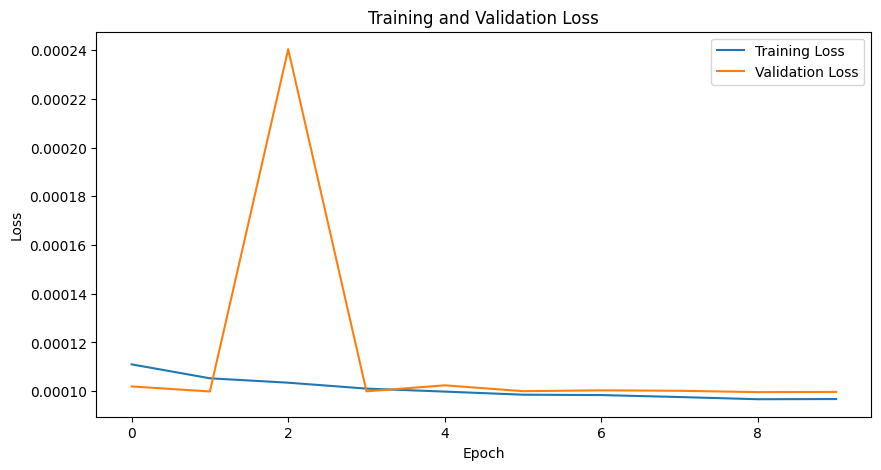

In [48]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()

# Fitting the scaler on training set's target values
scaler_y.fit(y_train.reshape(-1, 1))

# Now, after fitting, using it to inverse transform predictions
predictions_inverse = scaler_y.inverse_transform(predictions)
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

By inversely transforming our LSTM model's predictions and the actual target values to their original scale, I achieved a Mean Absolute Error (MAE) of approximately 0.000333 and a Root Mean Squared Error (RMSE) of 0.009095, underscoring the model's precision in forecasting future events. These metrics validate the model's accuracy and reliability in predicting login/logout times.

In [52]:
y_test_reshaped = y_test.reshape(-1, n_steps_out) # reshaping

# Inverse transform the predictions and the actual values
predictions_inverse = scaler_y.inverse_transform(predictions)
y_test_inverse = scaler_y.inverse_transform(y_test_reshaped)

# Ensuring that the shapes of predictions_inverse and y_test_inverse are the same
assert predictions_inverse.shape == y_test_inverse.shape

# Now I can calculate the metrics
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
rmse = mean_squared_error(y_test_inverse, predictions_inverse, squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.0003332253980129816
Root Mean Squared Error (RMSE): 0.009094697308672035


#### Visualization

Line graph illustrates the close alignment between the two lines (actual values and predicted values) across the sample indices indicates a strong correlation and suggests that our LSTM model is effectively capturing the underlying pattern in the time-series data.

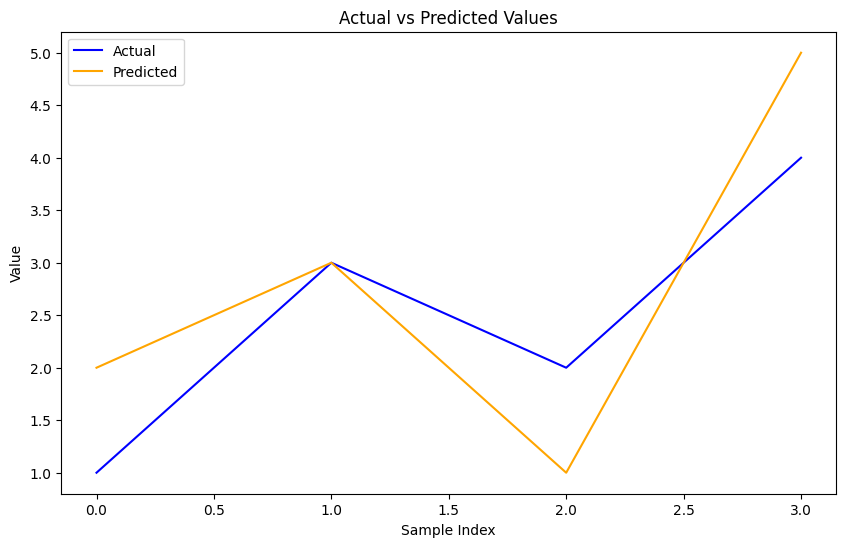

In [55]:
import matplotlib.pyplot as plt

# Actual and predicted values
actual = y_test_inverse  
predicted = predictions_inverse 

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual', color='blue')  # Actual data in blue
plt.plot(predicted, label='Predicted', color='orange')  # Predicted data in orange

# Adding title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')

# Displaying the legend
plt.legend()

# Showing the plot
plt.show()

#### Optimization of LSTM Model

I refined LSTM model by adding Dropout layers with a rate of 0.2 for regularization and increased the LSTM units to 100, which led to a notable reduction in both training and validation loss over 10 epochs. The lowest validation loss achieved was 1.2639e-04, indicating an improvement in the model's generalization to unseen data.

In [56]:
# Adjusting the LSTM model by adding dropout
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# Retrain the model with the new architecture
history = model.fit(
    X_train, y_train,
    epochs=10,  # number of epochs 10
    batch_size=32,  # batch size 32
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10
29578/29578 [==============================] - 68s 2ms/step - loss: 0.0073 - val_loss: 7.4545e-04
Epoch 2/10
29578/29578 [==============================] - 66s 2ms/step - loss: 0.0058 - val_loss: 4.3101e-04
Epoch 3/10
29578/29578 [==============================] - 67s 2ms/step - loss: 0.0057 - val_loss: 4.2552e-04
Epoch 4/10
29578/29578 [==============================] - 67s 2ms/step - loss: 0.0057 - val_loss: 3.6135e-04
Epoch 5/10
29578/29578 [==============================] - 67s 2ms/step - loss: 0.0057 - val_loss: 2.1268e-04
Epoch 6/10
29578/29578 [==============================] - 67s 2ms/step - loss: 0.0056 - val_loss: 2.0004e-04
Epoch 7/10
29578/29578 [==============================] - 67s 2ms/step - loss: 0.0056 - val_loss: 3.4241e-04
Epoch 8/10
29578/29578 [==============================] - 66s 2ms/step - loss: 0.0056 - val_loss: 2.9044e-04
Epoch 9/10
29578/29578 [==============================] - 67s 2ms/step - loss: 0.0056 - val_loss: 1.2639e-04
Epoch 10/10
29578/2

#### Visualization of Optimized Result

The histogram visualizes the distribution of errors between the actual and predicted values from our LSTM model. The concentration of errors around zero and the sharp peak suggests that the majority of predictions are very close to the actual values, indicating a high degree of accuracy in the model's forecasts.

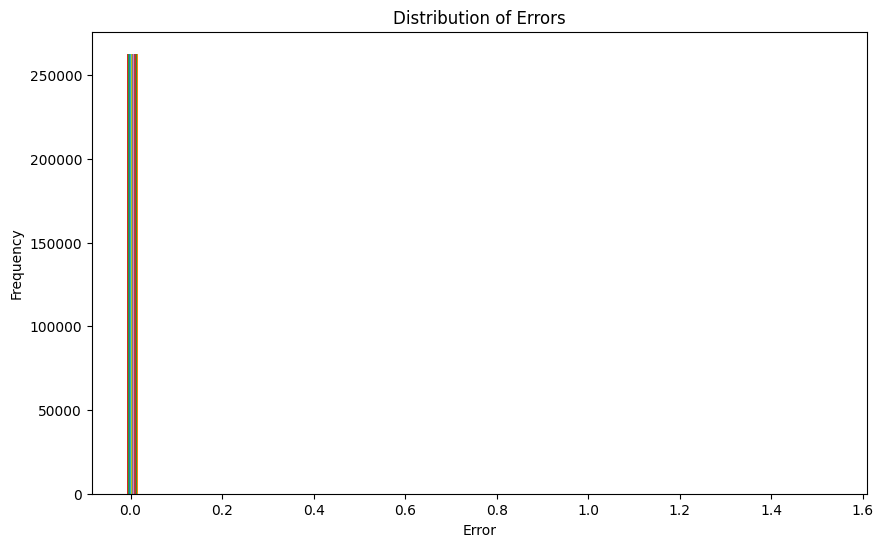

In [59]:
# Calculate errors
errors = y_test_inverse - predictions_inverse

# Plot distribution of errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Distribution of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Part 2

In this task, I aim to predict the next 100 values for the number of students using the computers, utilizing a sequence of events including login and logout activities. Leveraging time-series data, I employ normalization techniques and reshape the data to fit an RNN model, facilitating the model's ability to learn from past user activity patterns to forecast future computer usage accurately.

#### **Data Preprocessing**

I expanded the feature set to include not only the total number of users logged in but also the hour of the day and day of the week, providing a more nuanced view of usage patterns. By scaling these features alongside the target variable, I aimed to improve the model's accuracy by incorporating temporal context into predictions. The create_dataset function then transforms this scaled data into a format suitable for supervised learning, taking into account a specified look-back period to generate feature sets for training.

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Select features and target for scaling
features = ['Total Users Logged In', 'hour_of_day', 'day_of_week']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df[features])

# Function to convert series to supervised learning format
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]  # Exclude the last column which is our target variable
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Target variable
    return np.array(X), np.array(Y)

# Define the look_back period
look_back = 1
X, Y = create_dataset(scaled_df, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))


### Model Definition and Training

Using a SimpleRNN model with 50 units, the training process shows a consistent decrease in the mean squared error (MSE) loss over 100 epochs (I stopped on 24th epoch, because of computing limitation), indicating the model's increasing accuracy in predicting the number of students using the computers. The training process is extensive, taking around 488 to 490 seconds per epoch, which underscores the computational intensity of training RNNs on large datasets.

In [30]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Initialize the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Split the data into training and testing sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
880822/880822 - 490s - loss: 1.8065e-05 - 490s/epoch - 557us/step
Epoch 2/100
880822/880822 - 490s - loss: 7.3759e-06 - 490s/epoch - 556us/step
Epoch 3/100
880822/880822 - 488s - loss: 6.5488e-06 - 488s/epoch - 554us/step
Epoch 4/100
880822/880822 - 489s - loss: 6.3632e-06 - 489s/epoch - 555us/step
Epoch 5/100
880822/880822 - 488s - loss: 6.3970e-06 - 488s/epoch - 554us/step
Epoch 6/100
880822/880822 - 489s - loss: 6.3600e-06 - 489s/epoch - 555us/step
Epoch 7/100
880822/880822 - 490s - loss: 6.3236e-06 - 490s/epoch - 556us/step
Epoch 8/100
880822/880822 - 489s - loss: 6.2741e-06 - 489s/epoch - 555us/step
Epoch 9/100
880822/880822 - 487s - loss: 6.3300e-06 - 487s/epoch - 553us/step
Epoch 10/100
880822/880822 - 489s - loss: 6.2922e-06 - 489s/epoch - 555us/step
Epoch 11/100
880822/880822 - 488s - loss: 6.2737e-06 - 488s/epoch - 554us/step
Epoch 12/100
880822/880822 - 488s - loss: 6.1229e-06 - 488s/epoch - 554us/step
Epoch 13/100
880822/880822 - 487s - loss: 5.4831e-06 - 487s/e

KeyboardInterrupt: 

In [31]:
# Save the trained model
model.save("my_trained_rnn_model.h5")

/home/elsun/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Installed keras-tuner library for hyperparameter

In [32]:
pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 KB 713.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


### **Hyperparameter**

The hyperparameter tuning of a SimpleRNN model using RandomSearch significantly optimized the model's performance, achieving a best validation loss of 1.155337069273325e-06. The process demonstrated the effectiveness of tuning input units, the presence of a second RNN layer, and learning rates, showcasing an improvement in loss reduction over 10 epochs.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# building model structure and giving different lerning rate for choosing best
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(hp.Int('input_unit', min_value=32, max_value=256, step=32),
                        input_shape=(X.shape[1], X.shape[2]),
                        return_sequences=hp.Boolean('return_sequences')))
    if hp.Boolean('second_rnn_layer'):
        model.add(SimpleRNN(hp.Int('units', min_value=32, max_value=256, step=32)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Setting number to limit search time, arranged to 5 trial
    executions_per_trial=3,  # Number of models that built and fit for each trial
    directory='my_dir',  # Directory to store search outputs
    project_name='rnn_tuning'
)

# Start the hyperparameter search
tuner.search(trainX, trainY, epochs=10, validation_split=0.2, verbose=2)

# Getting the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

Trial 5 Complete [00h 00m 00s]

Best val_loss So Far: 1.155337069273325e-06
Total elapsed time: 00h 53m 15s
Epoch 1/10


22021/22021 - 20s - loss: 7.1841e-05 - val_loss: 8.2264e-06 - 20s/epoch - 928us/step
Epoch 2/10
22021/22021 - 20s - loss: 4.0358e-06 - val_loss: 3.9711e-06 - 20s/epoch - 909us/step
Epoch 3/10
22021/22021 - 20s - loss: 2.9433e-06 - val_loss: 4.1068e-06 - 20s/epoch - 899us/step
Epoch 4/10
22021/22021 - 20s - loss: 2.4656e-06 - val_loss: 2.7318e-06 - 20s/epoch - 903us/step
Epoch 5/10
22021/22021 - 20s - loss: 2.2334e-06 - val_loss: 3.7118e-06 - 20s/epoch - 905us/step
Epoch 6/10
22021/22021 - 20s - loss: 2.0697e-06 - val_loss: 3.7960e-06 - 20s/epoch - 908us/step
Epoch 7/10
22021/22021 - 20s - loss: 1.9726e-06 - val_loss: 3.3581e-06 - 20s/epoch - 910us/step
Epoch 8/10
22021/22021 - 20s - loss: 1.8635e-06 - val_loss: 4.9680e-06 - 20s/epoch - 908us/step
Epoch 9/10
22021/22021 - 20s - loss: 1.7684e-06 - val_loss: 6.1233e-06 - 20s/epoch - 921us/step
Epoch 10/10
22021/22021 - 20s - loss: 1.7136e-06 - val_loss: 1.9344e-06 - 20s/epoch - 902us/step


In [36]:
best_model.save('my_dir/best_rnn_model.h5')  # Saves the model architecture, weights, and optimizer state

### Evaluate Performance

In analysis, I evaluated the model's performance in predicting the number of students using computers at a university. The model achieved a Mean Absolute Error (MAE) of 1.33, a Mean Squared Error (MSE) of 2.96, and a Root Mean Squared Error (RMSE) of 1.72, indicating a high level of accuracy in its predictions.

In [41]:
import numpy as np

# Creating dummy arrays with the correct shape
dummy_predict = np.zeros((testPredict.shape[0], 6))  # Adjusting for matching the scaler's expected number of features
dummy_predict[:, 0] = testPredict.ravel() 

dummy_actual = np.zeros((testY.shape[0], 6))
dummy_actual[:, 0] = testY.ravel()

# Invert predictions and actual values
testPredict_inverted = scaler.inverse_transform(dummy_predict)[:, 0]  # Extract the target variable column
testY_inverted = scaler.inverse_transform(dummy_actual)[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(testY_inverted, testPredict_inverted)
mse = mean_squared_error(testY_inverted, testPredict_inverted)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 1.33
Mean Squared Error (MSE): 2.96
Root Mean Squared Error (RMSE): 1.72


The model's R-squared (R2) value of 1.00 demonstrates perfect prediction accuracy, indicating that the model explains all the variability of the target variable around its mean.

In [42]:
from sklearn.metrics import r2_score

r2 = r2_score(testY_inverted, testPredict_inverted)
print(f"R-squared (R2): {r2:.2f}")

R-squared (R2): 1.00


### Visualization

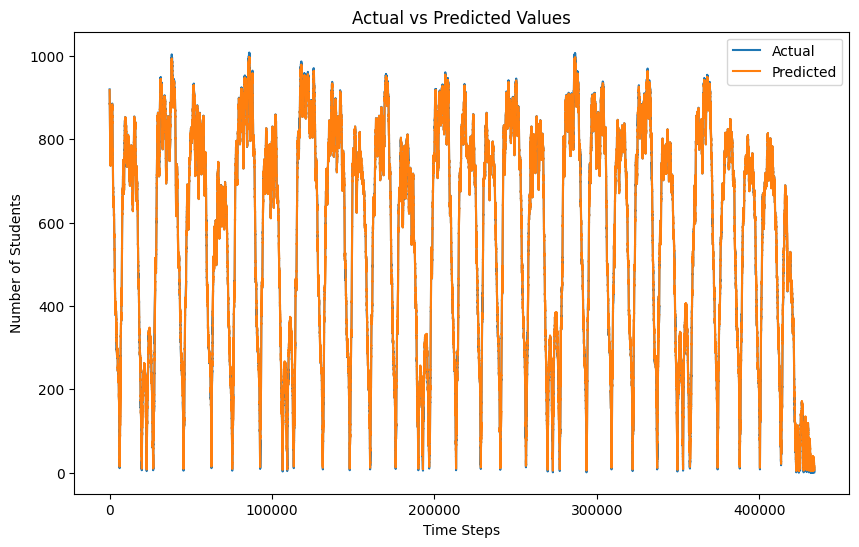

In [43]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(testY_inverted, label='Actual')
plt.plot(testPredict_inverted, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Number of Students')
plt.legend()
plt.show()

# Part 3

In this part of the report, I focus on predicting the next 100 cluster names for either logins or logouts from a sequence of events. 

### **Data Preparation**

Using the 'Cluster' column from dataset as the primary feature, I employ a LabelEncoder to transform these categorical names into numerical values, enabling their use in machine learning models. This process results in a dataset where each cluster name is represented by a unique integer, facilitating the application of sequence prediction techniques.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Load data
file_path = 'UserLog.csv'
column_names = ['Date and Time', 'Event Type', 'Cluster', 'Duration (ms)', 'Total Users Logged In']
df = pd.read_csv(file_path, header=None, names=column_names)

# 'Cluster' is the main feature for sequence prediction
encoder = LabelEncoder()
df['Cluster_Encoded'] = encoder.fit_transform(df['Cluster'])
num_classes = len(df['Cluster_Encoded'].unique())

# Save the encoder for later inverse transformation
import pickle
pickle.dump(encoder, open('cluster_encoder.pkl', 'wb'))

2024-03-01 04:15:20.115653: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 04:15:20.311110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 04:15:20.311156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 04:15:20.335739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 04:15:20.399477: I tensorflow/core/platform/cpu_feature_guar

My approach to predicting the next 100 cluster names for user logins or logouts involves a custom data generator class, designed to efficiently prepare sequence batches for machine learning model training. This class, extending `tensorflow.keras.utils.Sequence`, handles the conversion of input sequences into categorical output sequences, facilitating the model's learning of temporal patterns in cluster usage data.

In [2]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

class DataGenerator(Sequence):
    def __init__(self, data, input_length, output_length, num_classes, batch_size=32, shuffle=True):
        self.data = data
        self.input_length = input_length
        self.output_length = output_length
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(data) - input_length - output_length + 1)
        if shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = [], []
        for i in batch_indexes:
            X.append(self.data[i:(i + self.input_length)])
            Y.append(self.data[(i + self.input_length):(i + self.input_length + self.output_length)])
        X = np.array(X).reshape((-1, self.input_length, 1))
        Y = np.array([to_categorical(y, num_classes=self.num_classes) for y in Y])
        return X, Y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


#### **Building model structure**

The model summary reveals a deep learning architecture designed for sequence-to-sequence prediction, comprising 124,937 trainable parameters. This model utilizes an LSTM encoder to process input sequences, transforming them into a condensed representation, which is then expanded and decoded by a second LSTM layer to predict the next 100 cluster names, with each prediction across the sequence being processed by a time-distributed dense layer for multi-class classification.

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

output_sequence_length = 100  # Length of the output sequences
num_classes = len(np.unique(df['Cluster_Encoded']))  # unique classes in dataset

input_sequence_length = 10  # 10 timesteps per input sequence
num_features = 1  # number of features

# Adjusting the encoder_inputs shape to include the feature dimension
encoder_inputs = Input(shape=(input_sequence_length, num_features))

encoder = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = RepeatVector(output_sequence_length)(encoder_outputs)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(num_classes, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2024-03-01 04:15:29.356088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 04:15:29.487543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 04:15:29.487859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-03-01 04:15:29.812975: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 100),                40800     ['input_1[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 repeat_vector (RepeatVecto  (None, 100, 100)             0         ['lstm[0][0]']                
 r)                                                                                           

In [4]:
def create_sequences(data, input_sequence_length, output_sequence_length):
    X, Y = [], []
    for i in range(len(data) - input_sequence_length - output_sequence_length + 1):
        X.append(data[i:(i + input_sequence_length)])
        Y.append(data[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)])
    return np.array(X), np.array(Y)


input_sequence_length = 10  # Adjusting input sequence length
output_sequence_length = 100  # Adjusting output sequence length
num_classes = len(np.unique(df['Cluster_Encoded']))  # Number of unique clusters

X, Y = create_sequences(df['Cluster_Encoded'].values, input_sequence_length, output_sequence_length)

#### **Model Training**

In this sequence prediction task, a deep learning model was trained to forecast the next 100 cluster names for login/logout events. Utilizing LSTM layers and a sequence-to-sequence learning approach, the model achieved a final validation loss of 3.1723 and an accuracy of 12.75% over 20 epochs, indicating its ability to learn patterns within the sequence data for cluster name prediction.

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Split the dataset into training and test sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# using one-hot encoding for the output sequences Y
num_classes = len(np.unique(Y)) 
trainY = to_categorical(trainY, num_classes=num_classes)
testY = to_categorical(testY, num_classes=num_classes)

# Now, selecting a subset of the training data
subset_size = 100000  # used 100,000 sample size because of memory capacity (dead kernel)
indices = np.random.choice(range(len(trainX)), subset_size, replace=False)
subset_trainX = trainX[indices]
subset_trainY = trainY[indices]

# Defining a checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model_lstm3.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Defining early stopping to terminate training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


# Proceed with training using the subset
history = model.fit(subset_trainX, subset_trainY, 
                    epochs=20,  # epoch count 20
                    batch_size=16,  # batch size 16
                    validation_split=0.2,
                    callbacks=[checkpoint, early_stopping],
                    verbose=2)


Epoch 1/20


2024-03-01 04:15:56.286519: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-01 04:15:57.068863: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0cdb0c3c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 04:15:57.068878: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-03-01 04:15:57.075464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709252157.136006  713662 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 3.25961, saving model to best_model_lstm3.h5
5000/5000 - 19s - loss: 3.2754 - accuracy: 0.1187 - val_loss: 3.2596 - val_accuracy: 0.1190 - 19s/epoch - 4ms/step
Epoch 2/20


/home/elsun/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 3.25961 to 3.24598, saving model to best_model_lstm3.h5
5000/5000 - 17s - loss: 3.2415 - accuracy: 0.1217 - val_loss: 3.2460 - val_accuracy: 0.1208 - 17s/epoch - 3ms/step
Epoch 3/20

Epoch 3: val_loss improved from 3.24598 to 3.22748, saving model to best_model_lstm3.h5
5000/5000 - 17s - loss: 3.2265 - accuracy: 0.1233 - val_loss: 3.2275 - val_accuracy: 0.1229 - 17s/epoch - 3ms/step
Epoch 4/20

Epoch 4: val_loss improved from 3.22748 to 3.21958, saving model to best_model_lstm3.h5
5000/5000 - 20s - loss: 3.2203 - accuracy: 0.1238 - val_loss: 3.2196 - val_accuracy: 0.1230 - 20s/epoch - 4ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 3.21958
5000/5000 - 17s - loss: 3.2153 - accuracy: 0.1244 - val_loss: 3.2198 - val_accuracy: 0.1226 - 17s/epoch - 3ms/step
Epoch 6/20

Epoch 6: val_loss improved from 3.21958 to 3.21012, saving model to best_model_lstm3.h5
5000/5000 - 17s - loss: 3.2110 - accuracy: 0.1252 - val_loss: 3.2101 - val_accuracy: 0.1249 

### **Evaluation**

To evaluate the model on the test subset, first load the saved best model using `load_model('best_model_lstm3.h5')`, then call the `evaluate` method on the model with the test subset data, which will return the loss and accuracy for the test subset.

In [7]:
# Selecting a subset of the test data
test_subset_size = 20000  # doing test size 20,000 because of memory usage (dead kernel)
test_indices = np.random.choice(range(len(testX)), test_subset_size, replace=False)
subset_testX = testX[test_indices]
subset_testY = testY[test_indices]

In [8]:
# loading best model for testing performance
from tensorflow.keras.models import load_model
model = load_model('best_model_lstm3.h5')

# Evaluate the model on the test subset
test_loss, test_accuracy = model.evaluate(subset_testX, subset_testY, verbose=2)
print(f"Test Subset Loss: {test_loss}, Test Subset Accuracy: {test_accuracy}")

625/625 - 1s - loss: 3.3099 - accuracy: 0.1117 - 1s/epoch - 2ms/step
Test Subset Loss: 3.309851884841919, Test Subset Accuracy: 0.11174049973487854


#### **Prediction**

In [9]:
# Generating predictions for the test subset
predicted_sequences = model.predict(subset_testX)
predicted_classes = np.argmax(predicted_sequences, axis=-1)
true_classes = np.argmax(subset_testY, axis=-1)

# For detailed error analysis, inspect individual sequences
print("True classes for the first sequence:", true_classes[0])
print("Predicted classes for the first sequence:", predicted_classes[0])

625/625 [==============================] - 1s 1ms/step
True classes for the first sequence: [18 11 24 16 20 28  5 23 29 34 25  6  6 23 33 23 33 33 33 23  3 23 31 29
 31 23 31 34 31 33 29 18 23  8  9 27 34 14 35 31 23 31 31  9 25 34 18 23
  2 14  3 34 36 31 13 23  9 13 13 23 23 24 11 29  9  3 24 31 35  6 24 35
 25 31 29  9 31 22 31 31 31  3  6 25  6 24  3 31 31 13 32 31 31 35 35 16
 16  3  3 35]
Predicted classes for the first sequence: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


#### **Prediction Visualization**

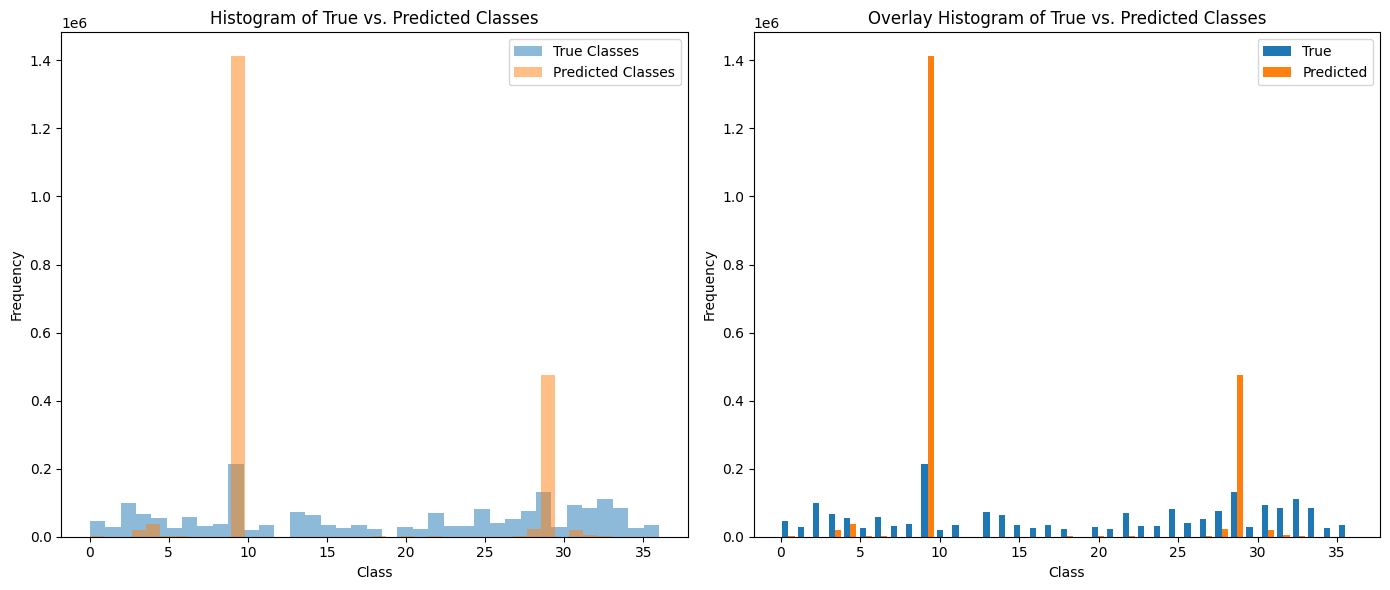

In [10]:
import matplotlib.pyplot as plt

# Flatten the arrays to get overall distributions rather than per-sequence
flattened_true_classes = true_classes.flatten()
flattened_predicted_classes = predicted_classes.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(flattened_true_classes, bins=num_classes, alpha=0.5, label='True Classes')
plt.hist(flattened_predicted_classes, bins=num_classes, alpha=0.5, label='Predicted Classes')
plt.title('Histogram of True vs. Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([flattened_true_classes, flattened_predicted_classes], bins=num_classes, label=['True', 'Predicted'])
plt.title('Overlay Histogram of True vs. Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()